# Experiments on MDVR-KCL Dataset using the .wav segments


In [9]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import auc
#from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Using Acoustic Features alone

### Read in the data that was extracted

In [10]:
# only acoustic features
df = pd.read_csv("../MDVR_acoustic_features_chunks.csv")
#df = shuffle(df)
#df.reset_index(inplace=True, drop=True)
df.drop('voiceID', inplace = True, axis = 1)
df['label'].value_counts()
df = df.dropna()
df.head()


,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,label
0,231.250953,45.480073,16.525302,0.027821,0.000121,0.011726,0.011947,0.085180,0.922601,0.028993,0.049585,0
1,201.477299,14.236377,18.961886,0.014327,0.000071,0.006781,0.007266,0.075751,0.843053,0.021091,0.034795,0
2,209.285317,29.051820,12.840174,0.029609,0.000143,0.013380,0.009806,0.078756,0.813759,0.028769,0.037729,0
3,221.819604,31.556270,16.250999,0.027461,0.000123,0.012908,0.015317,0.088893,0.941172,0.033405,0.054926,0
4,199.675876,6.519508,14.700531,0.026505,0.000134,0.014263,0.016973,0.078197,0.684674,0.030303,0.049475,0


In [11]:
# shape
print(df.shape)

# descriptions
print(df.describe())

# class distribution
print(df.groupby('label').size())

(808, 12)
         meanF0Hz   stdevF0Hz         HNR  localJitter  localabsoluteJitter  \
count  808.000000  808.000000  808.000000   808.000000           808.000000   
mean   179.784643   25.144978   13.091164     0.022284             0.000134   
std     47.328209   17.955716    3.185657     0.011296             0.000075   
min     92.441819    1.031706    2.928637     0.003969             0.000020   
25%    143.268451   12.156897   10.916644     0.016458             0.000084   
50%    182.170458   20.699903   12.878943     0.020723             0.000118   
75%    206.928781   33.558460   15.171925     0.025975             0.000163   
max    446.425562  143.864146   24.281832     0.124222             0.000672   

        rapJitter  ppq5Jitter  localShimmer  localdbShimmer  apq3Shimmer  \
count  808.000000  808.000000    808.000000      808.000000   808.000000   
mean     0.009700    0.010928      0.090910        0.892078     0.033753   
std      0.005744    0.007887      0.030945       

### EDA - Check outliers Visualization

<Figure size 2160x2160 with 0 Axes>

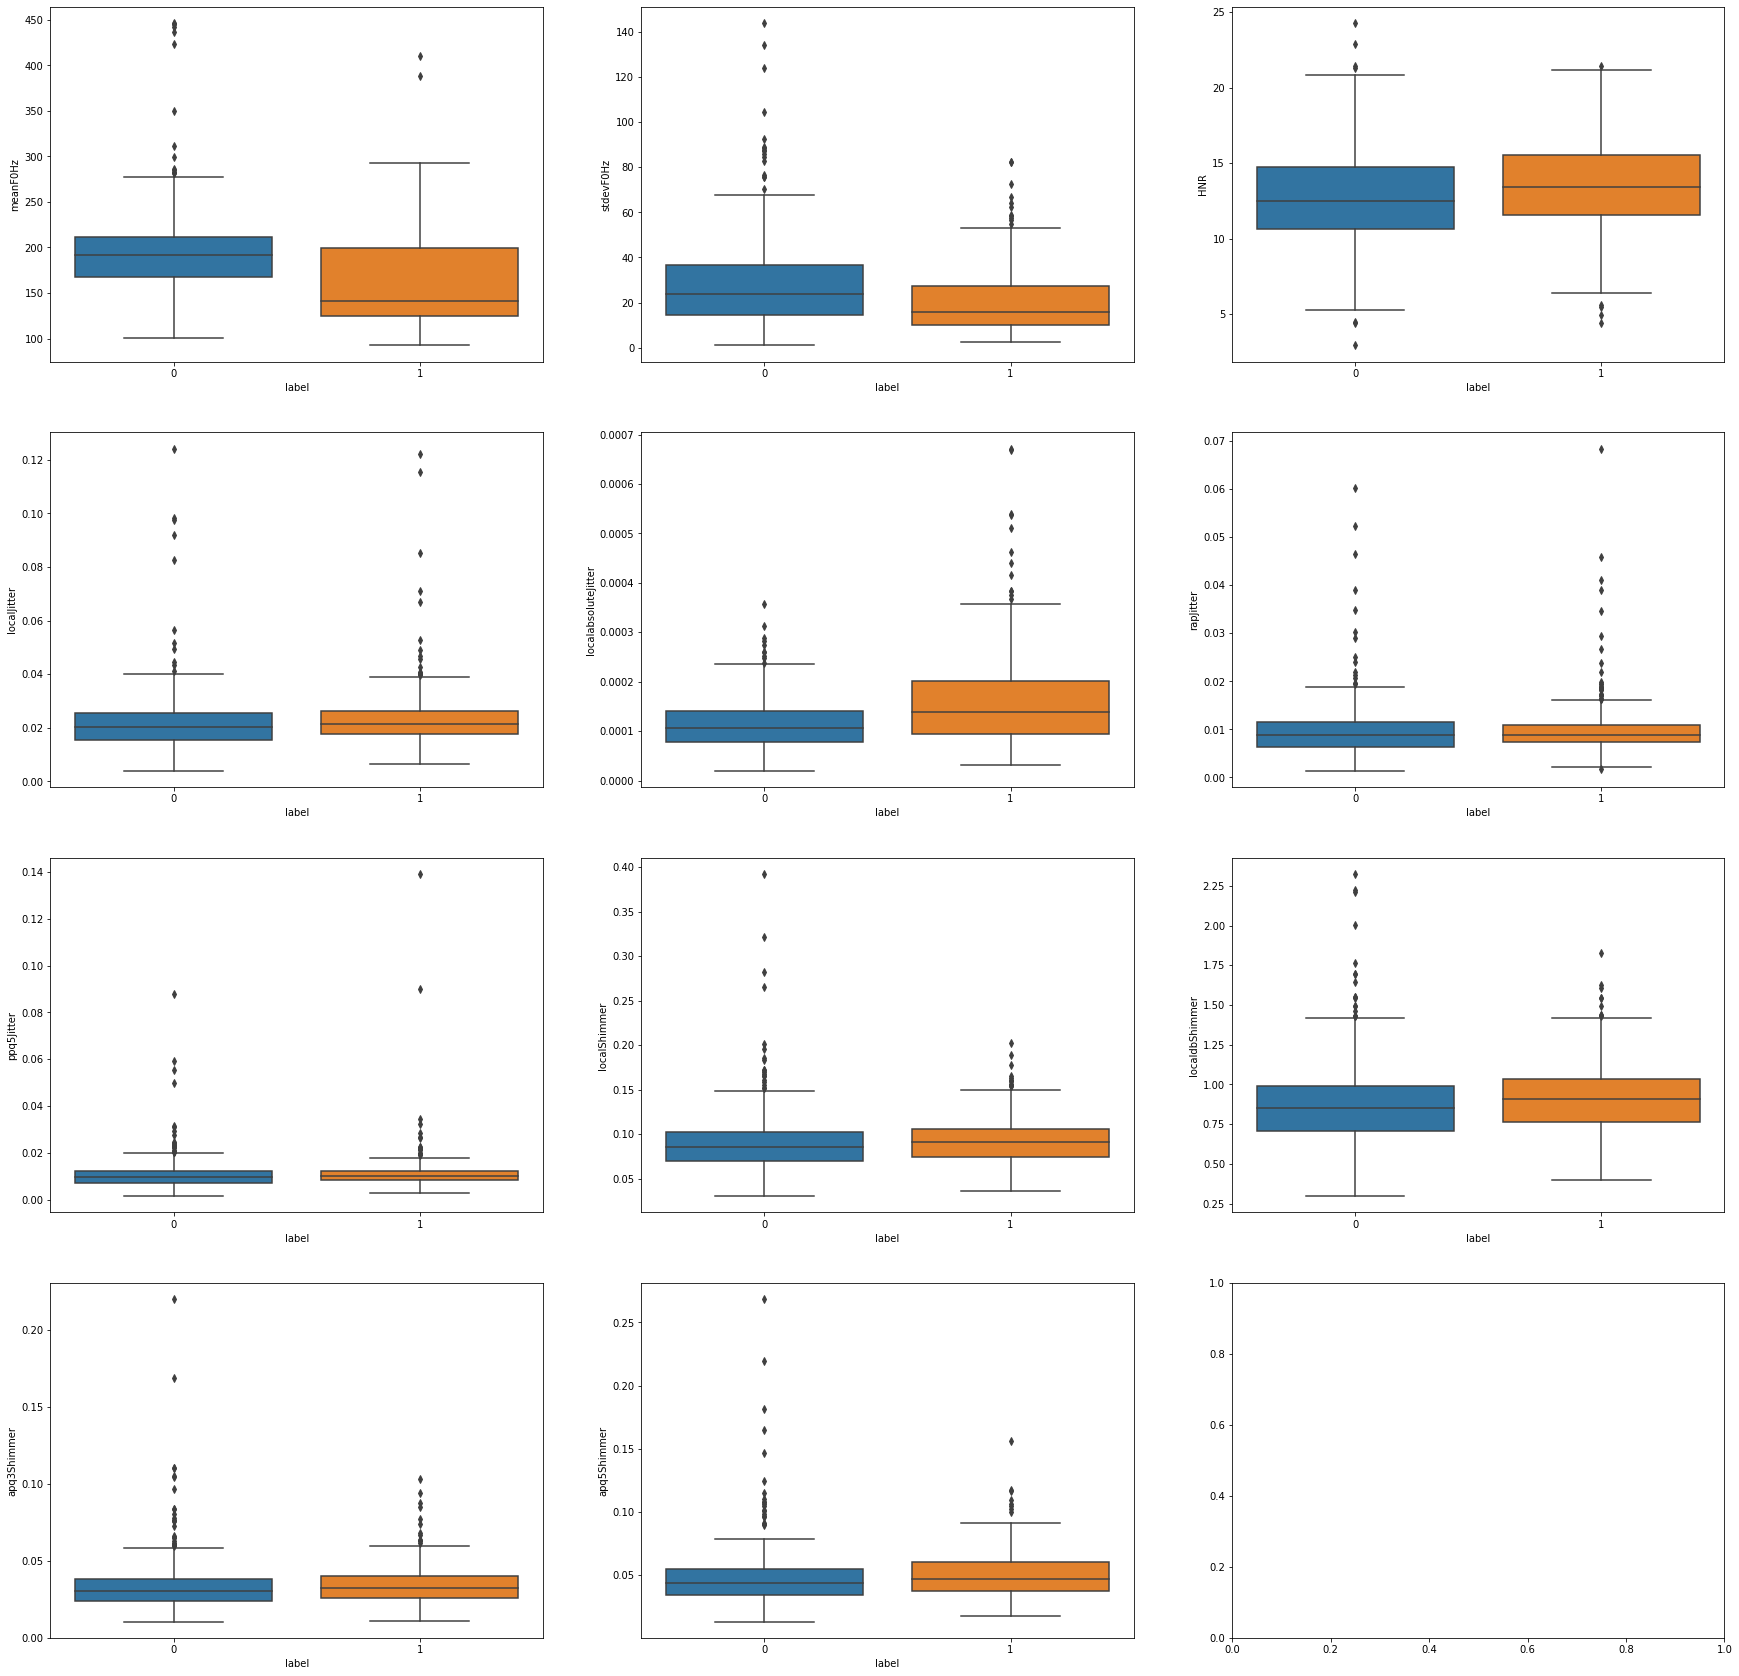

In [12]:
# histograms
plt.figure(figsize=(30,30))
#df_all.hist(figsize=(30,30))
#plt.show()

#box plot to check outliers
cols = df.columns.drop('label')
fig, ax = plt.subplots(4,3, figsize=(30,30))
for i,t in enumerate(cols):
    sns.boxplot(y=t, x= "label", data=df, ax=ax[i//3,i % 3])
plt.show()




In [13]:
df_jitter = df.sort_values("localabsoluteJitter")
Q1=df_jitter['localabsoluteJitter'].quantile(0.25)
Q3=df_jitter['localabsoluteJitter'].quantile(0.75)
IQR=Q3-Q1
print(Q1)
print(Q3)
print(IQR)
Lower_Whisker = Q1 - 1.5*IQR
Upper_Whisker = Q3 + 1.5*IQR

df_1 = df_jitter[df_jitter['localabsoluteJitter'] > Upper_Whisker]
df_1.append(df_jitter[df_jitter['localabsoluteJitter'] < Lower_Whisker])
df_1

8.385187208443277e-05
0.0001632567819324
7.940490984796725e-05


,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,label
420,436.526891,49.426400,17.290929,0.124222,0.000283,0.060130,0.059168,0.172404,1.416609,0.110298,0.043545,0
695,105.624426,51.261106,14.181993,0.029655,0.000285,0.010280,0.015782,0.076714,0.849089,0.022786,0.038751,1
539,118.070067,9.636819,10.699646,0.033656,0.000286,0.014336,0.015074,0.116175,1.141910,0.042764,0.058444,1
704,122.925231,8.232303,14.867126,0.035302,0.000287,0.018468,0.017671,0.082776,0.824150,0.028361,0.039233,1
186,349.748554,85.982228,17.152853,0.092147,0.000288,0.046544,0.023419,0.131716,1.091028,0.054938,0.066203,0
692,102.620464,13.859461,14.239776,0.029050,0.000288,0.009480,0.009917,0.058137,0.567546,0.017158,0.024261,1
689,105.173298,22.991949,14.099778,0.030932,0.000296,0.010441,0.013938,0.075083,0.740534,0.021738,0.036424,1
696,93.014171,9.442112,13.019803,0.027584,0.000297,0.007696,0.013530,0.074712,0.749408,0.025947,0.041783,1
697,99.176686,17.190880,12.637254,0.030614,0.000309,0.009385,0.015430,0.064547,0.654457,0.022477,0.030985,1
515,110.706257,10.102389,9.890545,0.034401,0.000311,0.012094,0.014893,0.108543,1.029208,0.025679,0.051402,1


### Split dataset

In [14]:
#separate dependent and independent variable for acoustic features only
X = df.iloc[:, :-1]
df_X = df.iloc[:, :-1].values
df_Y = df.iloc[:,-1].values

# Split the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size = 0.3, random_state = 0)

### Feature scaling

In [15]:
# Scale for acoustic features
#sc = StandardScaler()
sc = MinMaxScaler()
#sc = RobustScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10
0,0.154648,0.012578,0.787054,0.045324,0.065681,0.049453,0.027517,0.117502,0.140266,0.171648,0.150775
1,0.359383,0.138233,0.527694,0.146881,0.118045,0.124615,0.059992,0.208179,0.392777,0.114899,0.090757
2,0.266854,0.158108,0.644371,0.082157,0.082628,0.042779,0.024084,0.126883,0.194980,0.143321,0.118694
3,0.989576,0.300506,0.481678,0.665703,0.253371,0.560716,0.625995,0.457918,0.610710,0.501694,0.186052
4,0.492156,0.149232,0.118242,0.243871,0.159527,0.185294,0.106677,0.324000,0.515990,0.199637,0.107838
...,...,...,...,...,...,...,...,...,...,...,...
560,0.274639,0.178036,0.705424,0.134340,0.129217,0.107191,0.050935,0.235467,0.330539,0.297956,0.216335
561,0.179311,0.269568,0.364460,0.209696,0.250382,0.185847,0.066050,0.194868,0.300701,0.267327,0.150002
562,0.079025,0.059888,0.477472,0.110413,0.186168,0.065168,0.034257,0.129020,0.184829,0.147221,0.131005
563,0.144036,0.093019,0.734637,0.153207,0.206145,0.132728,0.085890,0.159813,0.276885,0.171980,0.125916


# *****************KNN Experiments******************

## Build model
### without tuning the hyperparameters

In [16]:
###### KNNN ###########
# Fit classifier to the Training set
#KNN
model_knn = KNeighborsClassifier(n_neighbors = 10)
model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

accuracy_knn = ((conf_matrix_knn[0,0] + conf_matrix_knn[1,1])/(conf_matrix_knn[0,0] +conf_matrix_knn[0,1]+conf_matrix_knn[1,0]+conf_matrix_knn[1,1]))*100


print(accuracy_knn)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn))

print(y_pred_knn)

print(conf_matrix_knn)



71.60493827160494
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       137
           1       0.74      0.54      0.62       106

    accuracy                           0.72       243
   macro avg       0.72      0.70      0.70       243
weighted avg       0.72      0.72      0.71       243

0.6958752237983749
[0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0
 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0
 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0
 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1
 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1
 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
[[117  20]
 [ 49  57]]


## Hyperparameter tuning for KNN

In [17]:
########Hyperparameter tuning for KNN####################
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,20)) #neighbours must be < number of samples (22)
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

Best leaf_size: 1
Best p: 1
Best n_neighbors: 12
Best Score: 0.800062656641604
Best Hyperparameters: {'leaf_size': 1, 'n_neighbors': 12, 'p': 1}
{'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'p': [1, 2]}
72.42798353909465
              precision    recall  f1-score   support

           0       0.72      0.84      0.77       137
           1       0.73      0.58      0.65       106

    accuracy                           0.72       243
   macro avg       0.73      0.71      0.71       243
weighted avg       0.73      0.72      0.72       243

0.707443878253684
[0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0
 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0
 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0

## Build Model
### using the optimal parameters gotten above

In [22]:
model_knn = KNeighborsClassifier(n_neighbors = 12, p = 1, leaf_size = 1)
model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

accuracy_knn = ((conf_matrix_knn[0,0] + conf_matrix_knn[1,1])/(conf_matrix_knn[0,0] +conf_matrix_knn[0,1]+conf_matrix_knn[1,0]+conf_matrix_knn[1,1]))*100


print(accuracy_knn)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn))

print(y_pred_knn)
print(y_test)

print(conf_matrix_knn)

####################using the acoustic + MFCC


72.42798353909465
              precision    recall  f1-score   support

           0       0.72      0.84      0.77       137
           1       0.73      0.58      0.65       106

    accuracy                           0.72       243
   macro avg       0.73      0.71      0.71       243
weighted avg       0.73      0.72      0.72       243

0.707443878253684
[0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0
 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0
 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0
 0 0 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1
 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1
 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
[1 0 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0
 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 0 0 1 0

## Evaluation 


### Evaluation with Leave one out method -IGNORE

In [19]:
df_X = sc.fit_transform(df_X)
k_fold = KFold(n_splits=37)
#KNN
model_knn_kfold = KNeighborsClassifier(n_neighbors = 9, p =1, leaf_size = 1)
y_pred_kfold_knn = cross_val_predict(model_knn_kfold, df_X, df_Y, cv=k_fold)

scores = cross_val_score(model_knn_kfold, df_X, df_Y, scoring='accuracy', cv=k_fold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

print(df_Y)
print(y_pred_kfold_knn)
conf_matrix_knn_kfold = confusion_matrix(df_Y, y_pred_kfold_knn)
print("Confusion Matrix for KNN using k-fold (leave one out)")
print(conf_matrix_knn_kfold)


accuracy_knn_2 = ((conf_matrix_knn_kfold[0,0] + conf_matrix_knn_kfold[1,1])/(conf_matrix_knn_kfold[0,0] +conf_matrix_knn_kfold[0,1]+conf_matrix_knn_kfold[1,0]+conf_matrix_knn_kfold[1,1]))*100


print(accuracy_knn_2)

Accuracy: 0.723 (0.254)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 

### K Fold Evaluation using optimal paramaters. (k =4)


In [23]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_list = []
k_specificity = []
k_sensitivity = []
k_precision = []
k_f1 = []
for i in range (1,12):
    row = []
    row_specificity = []
    row_sensitivity = []
    row_precision = []
    row_f1 = []
    
    row.append(i)
    row_specificity.append(i)
    row_sensitivity.append(i)
    row_precision.append(i)
    row_f1.append(i)
    
    total = 0
    total_specificity = 0
    total_sensitivity = 0
    total_precision = 0
    total_f1 = 0
    
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)
        #print(Ytrain_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)

        #modelling
        model_knn_new = KNeighborsClassifier(n_neighbors = 9, p =1, leaf_size = 1)
        model_knn_new.fit(Xtrain_kfold, Ytrain_kfold)
        y_pred_knn_new = model_knn_new.predict(Xtest_kfold)

        conf_matrix_knn_kfold = confusion_matrix(Ytest_kfold, y_pred_knn_new)
        TN = conf_matrix_knn_kfold[0][0]
        FP = conf_matrix_knn_kfold[0][1]
        FN = conf_matrix_knn_kfold[1][0]
        TP = conf_matrix_knn_kfold[1][1]
        
        
        #total = (conf_matrix_knn_kfold[0,0] +conf_matrix_knn_kfold[0,1]+conf_matrix_knn_kfold[1,0]+conf_matrix_knn_kfold[1,1])

        #accuracy_knn_kfold = ((conf_matrix_knn_kfold[0,0] + conf_matrix_knn_kfold[1,1])/total)*100
        accuracy_knn_kfold = ((TP + TN) / (TP + TN + FP + FN)) * 100
        sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
        specificity_knn_kfold = (TN/(TN + FP)) * 100
        precision_knn_kfold = (TP/(TP+FP)) * 100
        f1_knn_kfold = 2 *((sensitivity_knn_kfold * precision_knn_kfold)/(sensitivity_knn_kfold + precision_knn_kfold))
        #sensitivity_knn_kfold = ((conf_matrix_knn_kfold[0,0] + conf_matrix_knn_kfold[1,1])/total)*100

        #print("Confusion Matrix:\n ", conf_matrix_knn_kfold)
        #print("Accuracy ", accuracy_knn_kfold)

        row.append(accuracy_knn_kfold)
        row_specificity.append(specificity_knn_kfold)
        row_sensitivity.append(sensitivity_knn_kfold)
        row_precision.append(precision_knn_kfold)
        row_f1.append(f1_knn_kfold)
        
        total += accuracy_knn_kfold
        total_specificity += specificity_knn_kfold
        total_sensitivity += sensitivity_knn_kfold
        total_precision += precision_knn_kfold
        total_f1 += f1_knn_kfold
        
        #plot roc only for the first iteration
        #if i == 1:
           # metrics.plot_roc_curve(model_knn_new, Xtest_kfold, Ytest_kfold,name='ROC fold {}'.format(j),
                     #    alpha=0.3, lw=1, ax=ax)
        
        
    average = row.append(total/parts)
    
    row_specificity.append(total_specificity/parts)
    row_sensitivity.append(total_sensitivity/parts)
    row_precision.append(total_precision/parts)
    row_f1.append(total_f1/parts)
        
    #print(row)
    k_list.append(row)
    k_specificity.append(row_specificity)
    k_sensitivity.append(row_sensitivity)
    k_precision.append(row_precision)
    k_f1.append(row_f1)
    
      
k_list = pd.DataFrame(k_list, columns=['Iteration','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("KNN Kfold Evaluation for MDVR-KCL Dataset - Classification Accuracy")
print(k_list)
    

k_specificity = pd.DataFrame(k_specificity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean specificity'])
print("KNN Kfold Evaluation for MDVR-KCL Dataset - Specificity")
print(k_specificity)

k_sensitivity = pd.DataFrame(k_sensitivity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean sensitivity/recall'])
print("KNN Kfold Evaluation for MDVR-KCL Dataset - Sensitivity/Recall")
print(k_sensitivity)

k_precision = pd.DataFrame(k_precision, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean precision'])
print("KNN Kfold Evaluation for MDVR-KCL Dataset - Precision")
print(k_precision)

k_f1 = pd.DataFrame(k_f1, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean f1 score'])
print("KNN Kfold Evaluation for MDVR-KCL Dataset - F1 score")
print(k_f1)
    
k_list
    
#print(df.sample(n=7))
#print(df)

#x = df.take(np.random.permutation(len(df))[:4])
#x= df.sample(n=7)
#print(x)
#print(df.drop(x))

#drop_indices = np.random.choice(df.index, 4, replace=False)
#df_subset = df.drop(drop_indices)
#print(drop_indices)
#print(df_subset)

    
    


Divided into 4 parts.


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
<ipython-input-23-1ca028e49b9b>:74: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
<ipython-input-23-1ca028e49b9b>:74: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataC

<ipython-input-23-1ca028e49b9b>:75: RuntimeWarning: invalid value encountered in longlong_scalars
  specificity_knn_kfold = (TN/(TN + FP)) * 100
c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
<ipython-input-23-1ca028e49b9b>:74: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
<ipython-input-23-1ca028e49b9b>:74: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity_knn_kfold 

KNN Kfold Evaluation for MDVR-KCL Dataset - Classification Accuracy
    Iteration     fold 1     fold 2     fold 3     fold 4  mean accuracy
0           1  60.891089  64.356436  61.386139  34.653465      55.321782
1           2  60.891089  64.356436  61.386139  34.653465      55.321782
2           3  60.891089  64.356436  61.386139  34.653465      55.321782
3           4  60.891089  64.356436  61.386139  34.653465      55.321782
4           5  60.891089  64.356436  61.386139  34.653465      55.321782
5           6  60.891089  64.356436  61.386139  34.653465      55.321782
6           7  60.891089  64.356436  61.386139  34.653465      55.321782
7           8  60.891089  64.356436  61.386139  34.653465      55.321782
8           9  60.891089  64.356436  61.386139  34.653465      55.321782
9          10  60.891089  64.356436  61.386139  34.653465      55.321782
10         11  60.891089  64.356436  61.386139  34.653465      55.321782
KNN Kfold Evaluation for MDVR-KCL Dataset - Specificity


<ipython-input-23-1ca028e49b9b>:75: RuntimeWarning: invalid value encountered in longlong_scalars
  specificity_knn_kfold = (TN/(TN + FP)) * 100


,Iteration,fold 1,fold 2,fold 3,fold 4,mean accuracy
0,1,60.891089,64.356436,61.386139,34.653465,55.321782
1,2,60.891089,64.356436,61.386139,34.653465,55.321782
2,3,60.891089,64.356436,61.386139,34.653465,55.321782
3,4,60.891089,64.356436,61.386139,34.653465,55.321782
4,5,60.891089,64.356436,61.386139,34.653465,55.321782
5,6,60.891089,64.356436,61.386139,34.653465,55.321782
6,7,60.891089,64.356436,61.386139,34.653465,55.321782
7,8,60.891089,64.356436,61.386139,34.653465,55.321782
8,9,60.891089,64.356436,61.386139,34.653465,55.321782
9,10,60.891089,64.356436,61.386139,34.653465,55.321782



# *****************Decision Tree Experiments***************

## Build model
### without tuning the hyperparameters

In [ ]:
###### KNNN ###########
# Fit classifier to the Training set
#Decision Tree
import matplotlib.pyplot as plt
model_dt = tree.DecisionTreeClassifier()
model_dt = model_dt.fit(X_train, y_train)

y_pred_knn = model_dt.predict(X_test)

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

accuracy_knn = ((conf_matrix_knn[0,0] + conf_matrix_knn[1,1])/(conf_matrix_knn[0,0] +conf_matrix_knn[0,1]+conf_matrix_knn[1,0]+conf_matrix_knn[1,1]))*100


print(accuracy_knn)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn))

print(y_pred_knn)

print(conf_matrix_knn)

plt.figure(figsize=(24,14))
tree.plot_tree(model_dt, filled=True, fontsize=14)

## Hyperparameter tuning for Decision Trees

In [ ]:
########Hyperparameter tuning for KNN####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
max_depth = list(range(1,10))
min_samples_split = list(range(2,10)) #neighbours must be < number of samples (22)
min_samples_leaf = list(range(1,5))
criterion=['gini','entropy']
#Convert to dictionary
hyperparameters = dict(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, criterion = criterion)
#Create new KNN object
dt_2 = tree.DecisionTreeClassifier()

cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(dt_2, hyperparameters, refit=True)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

## Build Model (Decision Tree)
### using the optimal parameters gotten above

In [ ]:
#model_dt = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
model_dt = tree.DecisionTreeClassifier(max_depth = 1, criterion='gini',min_samples_leaf=1, min_samples_split=2 )
model_dt = model_dt.fit(X_train, y_train)

y_pred_dt_2 = best_model.predict(X_test)

conf_matrix_dt_2 = confusion_matrix(y_test, y_pred_dt_2)

accuracy_dt_2 = ((conf_matrix_dt_2[0,0] + conf_matrix_dt_2[1,1])/(conf_matrix_dt_2[0,0] +conf_matrix_dt_2[0,1]+conf_matrix_dt_2[1,0]+conf_matrix_dt_2[1,1]))*100

print(conf_matrix_dt_2)
print(accuracy_dt_2)

## Evaluation 


### Evaluation with Leave one out method - IGNORE

In [ ]:
df_X = sc.fit_transform(df_X)
k_fold = KFold(n_splits=37)
#KNN
#model_knn_kfold = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
model_dt = tree.DecisionTreeClassifier(max_depth = 1, criterion='gini',min_samples_leaf=1, min_samples_split=2 )
y_pred_kfold_knn = cross_val_predict(model_dt, df_X, df_Y, cv=k_fold)
scores = cross_val_score(model_dt, df_X, df_Y, scoring='accuracy', cv=k_fold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

print(df_Y)
print(y_pred_kfold_knn)
conf_matrix_knn_kfold = confusion_matrix(df_Y, y_pred_kfold_knn)
print("Confusion Matrix for Dt using k-fold (leave one out)")
print(conf_matrix_knn_kfold)


accuracy_knn_2 = ((conf_matrix_knn_kfold[0,0] + conf_matrix_knn_kfold[1,1])/(conf_matrix_knn_kfold[0,0] +conf_matrix_knn_kfold[0,1]+conf_matrix_knn_kfold[1,0]+conf_matrix_knn_kfold[1,1]))*100


print(accuracy_knn_2)

### K Fold Evaluation using optimal paramaters. (k =4)


In [ ]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_dt_list = []
k_dt_specificity = []
k_dt_sensitivity = []
k_dt_precision = []
k_dt_f1 = []

for i in range (1,12):
    row = []
    row_specificity = []
    row_sensitivity = []
    row_precision = []
    row_f1 = []
    
    row.append(i)
    row_specificity.append(i)
    row_sensitivity.append(i)
    row_precision.append(i)
    row_f1.append(i)
    
    total = 0
    total_specificity = 0
    total_sensitivity = 0
    total_precision = 0
    total_f1 = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)

        #modelling
        #model_knn_new = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
        model_dt_new = tree.DecisionTreeClassifier(max_depth = 1, criterion='gini',min_samples_leaf=1, min_samples_split=2 )
        model_dt_new.fit(Xtrain_kfold, Ytrain_kfold)
        y_pred_dt_new = model_dt_new.predict(Xtest_kfold)

        #conf_matrix_dt_kfold = confusion_matrix(Ytest_kfold, y_pred_dt_new)
        conf_matrix_knn_kfold = confusion_matrix(Ytest_kfold, y_pred_dt_new)

        #accuracy_dt_kfold = ((conf_matrix_dt_kfold[0,0] + conf_matrix_dt_kfold[1,1])/(conf_matrix_dt_kfold[0,0] +conf_matrix_dt_kfold[0,1]+conf_matrix_dt_kfold[1,0]+conf_matrix_dt_kfold[1,1]))*100
        TN = conf_matrix_knn_kfold[0][0]
        FP = conf_matrix_knn_kfold[0][1]
        FN = conf_matrix_knn_kfold[1][0]
        TP = conf_matrix_knn_kfold[1][1]
        
    
        accuracy_knn_kfold = ((TP + TN) / (TP + TN + FP + FN)) * 100
        sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
        specificity_knn_kfold = (TN/(TN + FP)) * 100
        precision_knn_kfold = (TP/(TP+FP)) *100
        f1_knn_kfold = 2 *((sensitivity_knn_kfold * precision_knn_kfold)/(sensitivity_knn_kfold + precision_knn_kfold))


        row.append(accuracy_knn_kfold)
        row_specificity.append(specificity_knn_kfold)
        row_sensitivity.append(sensitivity_knn_kfold)
        row_precision.append(precision_knn_kfold)
        row_f1.append(f1_knn_kfold)
        
        total += accuracy_knn_kfold
        total_specificity += specificity_knn_kfold
        total_sensitivity += sensitivity_knn_kfold
        total_precision += precision_knn_kfold
        total_f1 += f1_knn_kfold

    average = row.append(total/parts)   
    row_specificity.append(total_specificity/parts)
    row_sensitivity.append(total_sensitivity/parts)
    row_precision.append(total_precision/parts)
    row_f1.append(total_f1/parts)
        
    #print(row)
    k_dt_list.append(row)
    k_dt_specificity.append(row_specificity)
    k_dt_sensitivity.append(row_sensitivity)
    k_dt_precision.append(row_precision)
    k_dt_f1.append(row_f1)
    
k_dt_list = pd.DataFrame(k_dt_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("Decsion Tree Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy")
print(k_dt_list)    

k_dt_specificity = pd.DataFrame(k_dt_specificity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean specificity'])
print("Decsion Tree Kfold Evaluation for MDVR-KCL Dataset - Specificity")
print(k_dt_specificity)

k_dt_sensitivity = pd.DataFrame(k_dt_sensitivity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean sensitivity/recall'])
print("Decsion Tree Kfold Evaluation for MDVR-KCL Dataset - Sensitivity/Recall")
print(k_dt_sensitivity)

k_dt_precision = pd.DataFrame(k_dt_precision, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean precision'])
print("Decsion Tree Kfold Evaluation for MDVR-KCL Dataset - Precision")
print(k_dt_precision)

k_dt_f1 = pd.DataFrame(k_dt_f1, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean f1 score'])
print("Decsion Tree Kfold Evaluation for MDVR-KCL Dataset - F1 score")
print(k_dt_f1)


    
    
    

    
    



# *****************SVM Experiments***************

## Build model
### without tuning the hyperparameters

In [ ]:
###### KNNN ###########
# Fit classifier to the Training set
#Decision Tree
import matplotlib.pyplot as plt
model_svm = svm.SVC()
model_svm = model_dt.fit(X_train, y_train)

y_pred_svm = model_dt.predict(X_test)

conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

accuracy_svm = ((conf_matrix_svm[0,0] + conf_matrix_svm[1,1])/(conf_matrix_svm[0,0] +conf_matrix_svm[0,1]+conf_matrix_svm[1,0]+conf_matrix_svm[1,1]))*100


print(accuracy_svm)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_svm))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_svm))

print(y_pred_svm)

print(conf_matrix_svm)


## Hyperparameter tuning for SVM

In [ ]:
########Hyperparameter tuning for SVM####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
C = [0.1, 1, 10, 100, 1000]
gamma = [1, 0.1, 0.01, 0.001, 0.0001]
kernel = ['rbf']

#Convert to dictionary
hyperparameters = dict(C=C, gamma=gamma, kernel=kernel)
#Create new KNN object
svm2 = svm.SVC()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(svm2, hyperparameters, refit=True)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

## Build Model (SVM)
### using the optimal parameters gotten above

In [ ]:
model_svm = svm.SVC(C = 10, gamma=0.1,kernel='rbf')
model_svm = model_svm.fit(X_train, y_train)

y_pred_svm_2 = best_model.predict(X_test)

conf_matrix_svm_2 = confusion_matrix(y_test, y_pred_svm_2)

accuracy_svm_2 = ((conf_matrix_svm_2[0,0] + conf_matrix_svm_2[1,1])/(conf_matrix_svm_2[0,0] +conf_matrix_svm_2[0,1]+conf_matrix_svm_2[1,0]+conf_matrix_svm_2[1,1]))*100

print(conf_matrix_svm_2)
print(accuracy_svm_2)

## Evaluation (SVM) 


### Evaluation with Leave one out method

In [ ]:
df_X = sc.fit_transform(df_X)
k_fold = KFold(n_splits=37)
#KNN
#model_knn_kfold = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
model_svm = svm.SVC(C = 10, gamma=0.1,kernel='rbf')
y_pred_kfold_svm = cross_val_predict(model_svm, df_X, df_Y, cv=k_fold)
scores = cross_val_score(model_svm, df_X, df_Y, scoring='accuracy', cv=k_fold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

print(df_Y)
print(y_pred_kfold_knn)
conf_matrix_svm_kfold = confusion_matrix(df_Y, y_pred_kfold_svm)
print("Confusion Matrix for Dt using k-fold (leave one out)")
print(conf_matrix_svm_kfold)


accuracy_svm_2 = ((conf_matrix_svm_kfold[0,0] + conf_matrix_svm_kfold[1,1])/(conf_matrix_svm_kfold[0,0] +conf_matrix_svm_kfold[0,1]+conf_matrix_svm_kfold[1,0]+conf_matrix_svm_kfold[1,1]))*100


print(accuracy_svm_2)

### K Fold Evaluation using optimal paramaters. (k =4)


In [ ]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_svm_list = []
k_svm_specificity = []
k_svm_sensitivity = []
k_svm_precision = []
k_svm_f1 = []

for i in range (1,12):
    row = []
    row_specificity = []
    row_sensitivity = []
    row_precision = []
    row_f1 = []
    
    row.append(i)
    row_specificity.append(i)
    row_sensitivity.append(i)
    row_precision.append(i)
    row_f1.append(i)
    
    total = 0
    total_specificity = 0
    total_sensitivity = 0
    total_precision = 0
    total_f1 = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)

        #modelling
        
        model_svm_new = svm.SVC(C = 10, gamma=0.1,kernel='rbf')
        model_svm_new.fit(Xtrain_kfold, Ytrain_kfold)
        y_pred_svm_new = model_svm_new.predict(Xtest_kfold)

        conf_matrix_knn_kfold = confusion_matrix(Ytest_kfold, y_pred_svm_new)

        #accuracy_dt_kfold = ((conf_matrix_dt_kfold[0,0] + conf_matrix_dt_kfold[1,1])/(conf_matrix_dt_kfold[0,0] +conf_matrix_dt_kfold[0,1]+conf_matrix_dt_kfold[1,0]+conf_matrix_dt_kfold[1,1]))*100
        TN = conf_matrix_knn_kfold[0][0]
        FP = conf_matrix_knn_kfold[0][1]
        FN = conf_matrix_knn_kfold[1][0]
        TP = conf_matrix_knn_kfold[1][1]
        
    
        accuracy_knn_kfold = ((TP + TN) / (TP + TN + FP + FN)) * 100
        sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
        specificity_knn_kfold = (TN/(TN + FP)) * 100
        precision_knn_kfold = (TP/(TP+FP)) *100
        f1_knn_kfold = 2 *((sensitivity_knn_kfold * precision_knn_kfold)/(sensitivity_knn_kfold + precision_knn_kfold))


        row.append(accuracy_knn_kfold)
        row_specificity.append(specificity_knn_kfold)
        row_sensitivity.append(sensitivity_knn_kfold)
        row_precision.append(precision_knn_kfold)
        row_f1.append(f1_knn_kfold)
        
        total += accuracy_knn_kfold
        total_specificity += specificity_knn_kfold
        total_sensitivity += sensitivity_knn_kfold
        total_precision += precision_knn_kfold
        total_f1 += f1_knn_kfold

    average = row.append(total/parts)   
    row_specificity.append(total_specificity/parts)
    row_sensitivity.append(total_sensitivity/parts)
    row_precision.append(total_precision/parts)
    row_f1.append(total_f1/parts)
        
    #print(row)
    k_svm_list.append(row)
    k_svm_specificity.append(row_specificity)
    k_svm_sensitivity.append(row_sensitivity)
    k_svm_precision.append(row_precision)
    k_svm_f1.append(row_f1)
    
k_svm_list = pd.DataFrame(k_svm_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("SVM Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy")
print(k_svm_list)    

k_svm_specificity = pd.DataFrame(k_svm_specificity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean specificity'])
print("SVM Kfold Evaluation for MDVR-KCL Dataset - Specificity")
print(k_svm_specificity)

k_svm_sensitivity = pd.DataFrame(k_svm_sensitivity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean sensitivity/recall'])
print("SVM Kfold Evaluation for MDVR-KCL Dataset - Sensitivity/Recall")
print(k_svm_sensitivity)

k_svm_precision = pd.DataFrame(k_svm_precision, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean precision'])
print("SVM Kfold Evaluation for MDVR-KCL Dataset - Precision")
print(k_svm_precision)

k_svm_f1 = pd.DataFrame(k_svm_f1, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean f1 score'])
print("SVM Kfold Evaluation for MDVR-KCL Dataset - F1 score")
print(k_svm_f1)


# *****************Naive Bayes Experiments***************

## Build model
### without tuning the hyperparameters

In [ ]:
###### KNNN ###########
# Fit classifier to the Training set
#NB
model_nb = GaussianNB()
model_nb = model_nb.fit(X_train, y_train)


y_pred_nb = model_nb.predict(X_test)

conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

accuracy_nb = ((conf_matrix_nb[0,0] + conf_matrix_nb[1,1])/(conf_matrix_nb[0,0] +conf_matrix_nb[0,1]+conf_matrix_nb[1,0]+conf_matrix_nb[1,1]))*100


print(accuracy_nb)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_nb))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_nb))

print(y_pred_nb)

print(conf_matrix_nb)


## Hyperparameter tuning for Naive Bayes

### NB doesnt have important parameters to tune

## Evaluation (Naive Bayes) 


### Evaluation with Leave one out method

In [ ]:
df_X = sc.fit_transform(df_X)
k_fold = KFold(n_splits=37)
#KNN
#model_knn_kfold = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
model_nb_2 = GaussianNB()
y_pred_kfold_nb = cross_val_predict(model_nb_2, df_X, df_Y, cv=k_fold)
scores = cross_val_score(model_nb_2, df_X, df_Y, scoring='accuracy', cv=k_fold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

print(df_Y)
print(y_pred_kfold_nb)
conf_matrix_nb_kfold = confusion_matrix(df_Y, y_pred_kfold_nb)
print("Confusion Matrix for Dt using k-fold (leave one out)")
print(conf_matrix_nb_kfold)


accuracy_nb_2 = ((conf_matrix_nb_kfold[0,0] + conf_matrix_nb_kfold[1,1])/(conf_matrix_nb_kfold[0,0] +conf_matrix_nb_kfold[0,1]+conf_matrix_nb_kfold[1,0]+conf_matrix_nb_kfold[1,1]))*100


print(accuracy_nb_2)

### K Fold Evaluation using optimal paramaters. (k =4)


In [ ]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_nb_list = []
k_nb_specificity = []
k_nb_sensitivity = []
k_nb_precision = []
k_nb_f1 = []

for i in range (1,12):
    row = []
    row_specificity = []
    row_sensitivity = []
    row_precision = []
    row_f1 = []
    
    row.append(i)
    row_specificity.append(i)
    row_sensitivity.append(i)
    row_precision.append(i)
    row_f1.append(i)
    
    total = 0
    total_specificity = 0
    total_sensitivity = 0
    total_precision = 0
    total_f1 = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)

        #modelling
        
        model_nb_new = GaussianNB()
        model_nb_new.fit(Xtrain_kfold, Ytrain_kfold)

        y_pred_nb_new = model_nb_new.predict(Xtest_kfold)

        conf_matrix_nb_kfold = confusion_matrix(Ytest_kfold, y_pred_nb_new)

        #accuracy_dt_kfold = ((conf_matrix_dt_kfold[0,0] + conf_matrix_dt_kfold[1,1])/(conf_matrix_dt_kfold[0,0] +conf_matrix_dt_kfold[0,1]+conf_matrix_dt_kfold[1,0]+conf_matrix_dt_kfold[1,1]))*100
        TN = conf_matrix_nb_kfold[0][0]
        FP = conf_matrix_nb_kfold[0][1]
        FN = conf_matrix_nb_kfold[1][0]
        TP = conf_matrix_nb_kfold[1][1]
        
    
        accuracy_knn_kfold = ((TP + TN) / (TP + TN + FP + FN)) * 100
        sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
        specificity_knn_kfold = (TN/(TN + FP)) * 100
        precision_knn_kfold = (TP/(TP+FP)) *100
        f1_knn_kfold = 2 *((sensitivity_knn_kfold * precision_knn_kfold)/(sensitivity_knn_kfold + precision_knn_kfold))


        row.append(accuracy_knn_kfold)
        row_specificity.append(specificity_knn_kfold)
        row_sensitivity.append(sensitivity_knn_kfold)
        row_precision.append(precision_knn_kfold)
        row_f1.append(f1_knn_kfold)
        
        total += accuracy_knn_kfold
        total_specificity += specificity_knn_kfold
        total_sensitivity += sensitivity_knn_kfold
        total_precision += precision_knn_kfold
        total_f1 += f1_knn_kfold

    average = row.append(total/parts)   
    row_specificity.append(total_specificity/parts)
    row_sensitivity.append(total_sensitivity/parts)
    row_precision.append(total_precision/parts)
    row_f1.append(total_f1/parts)
        
    #print(row)
    k_nb_list.append(row)
    k_nb_specificity.append(row_specificity)
    k_nb_sensitivity.append(row_sensitivity)
    k_nb_precision.append(row_precision)
    k_nb_f1.append(row_f1)
    
k_nb_list = pd.DataFrame(k_nb_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("Naive Bayes Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy")
print(k_nb_list)    

k_nb_specificity = pd.DataFrame(k_nb_specificity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean specificity'])
print("Naive Bayes Kfold Evaluation for MDVR-KCL Dataset - Specificity")
print(k_nb_specificity)

k_nb_sensitivity = pd.DataFrame(k_nb_sensitivity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean sensitivity/recall'])
print("Naive Bayes Kfold Evaluation for MDVR-KCL Dataset - Sensitivity/Recall")
print(k_nb_sensitivity)

k_nb_precision = pd.DataFrame(k_nb_precision, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean precision'])
print("Naive Bayes Kfold Evaluation for MDVR-KCL Dataset - Precision")
print(k_nb_precision)

k_nb_f1 = pd.DataFrame(k_nb_f1, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean f1 score'])
print("Naive Bayes Kfold Evaluation for MDVR-KCL Dataset - F1 score")
print(k_nb_f1)


# *****************Logistic Regression Experiments***************

## Build model
### without tuning the hyperparameters

In [ ]:
###### KNNN ###########
# Fit classifier to the Training set
#NB


model_lr = LogisticRegression(random_state=0)
model_lr = model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)

conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

accuracy_lr = ((conf_matrix_lr[0,0] + conf_matrix_lr[1,1])/(conf_matrix_lr[0,0] +conf_matrix_lr[0,1]+conf_matrix_lr[1,0]+conf_matrix_lr[1,1]))*100


print(accuracy_lr)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_lr))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_lr))

print(y_pred_lr)

print(conf_matrix_lr)


## Hyperparameter tuning for LR

In [ ]:
########Hyperparameter tuning for SVM####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

#Convert to dictionary
hyperparameters = dict(solver=solvers,penalty=penalty,C=c_values)
#Create new LR object
model_lr2 = LogisticRegression()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(model_lr2, hyperparameters, cv=cv)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

## Build Model (LR)
### using the optimal parameters gotten above

In [ ]:
model_lr = LogisticRegression(C= 10, penalty='l2',solver= 'newton-cg')
model_lr = model_lr.fit(X_train, y_train)

y_pred_lr_2 = best_model.predict(X_test)

conf_matrix_lr_2 = confusion_matrix(y_test, y_pred_lr_2)

accuracy_lr_2 = ((conf_matrix_lr_2[0,0] + conf_matrix_lr_2[1,1])/(conf_matrix_lr_2[0,0] +conf_matrix_lr_2[0,1]+conf_matrix_lr_2[1,0]+conf_matrix_lr_2[1,1]))*100

print(conf_matrix_lr_2)
print(accuracy_lr_2)

## Evaluation (LR) 


### K Fold Evaluation using optimal paramaters. (k =4)


In [ ]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_lr_list = []
k_lr_specificity = []
k_lr_sensitivity = []
k_lr_precision = []
k_lr_f1 = []

for i in range (1,12):
    row = []
    row_specificity = []
    row_sensitivity = []
    row_precision = []
    row_f1 = []
    
    row.append(i)
    row_specificity.append(i)
    row_sensitivity.append(i)
    row_precision.append(i)
    row_f1.append(i)
    
    total = 0
    total_specificity = 0
    total_sensitivity = 0
    total_precision = 0
    total_f1 = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)

        #modelling
        model_nb_new = LogisticRegression(C= 10, penalty='l2',solver= 'newton-cg')
        model_nb_new.fit(Xtrain_kfold, Ytrain_kfold)

        y_pred_nb_new = model_nb_new.predict(Xtest_kfold)

        conf_matrix_knn_kfold = confusion_matrix(Ytest_kfold, y_pred_nb_new)


        #accuracy_dt_kfold = ((conf_matrix_dt_kfold[0,0] + conf_matrix_dt_kfold[1,1])/(conf_matrix_dt_kfold[0,0] +conf_matrix_dt_kfold[0,1]+conf_matrix_dt_kfold[1,0]+conf_matrix_dt_kfold[1,1]))*100
        TN = conf_matrix_knn_kfold[0][0]
        FP = conf_matrix_knn_kfold[0][1]
        FN = conf_matrix_knn_kfold[1][0]
        TP = conf_matrix_knn_kfold[1][1]
        
    
        accuracy_knn_kfold = ((TP + TN) / (TP + TN + FP + FN)) * 100
        sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
        specificity_knn_kfold = (TN/(TN + FP)) * 100
        precision_knn_kfold = (TP/(TP+FP)) *100
        f1_knn_kfold = 2 *((sensitivity_knn_kfold * precision_knn_kfold)/(sensitivity_knn_kfold + precision_knn_kfold))


        row.append(accuracy_knn_kfold)
        row_specificity.append(specificity_knn_kfold)
        row_sensitivity.append(sensitivity_knn_kfold)
        row_precision.append(precision_knn_kfold)
        row_f1.append(f1_knn_kfold)
        
        total += accuracy_knn_kfold
        total_specificity += specificity_knn_kfold
        total_sensitivity += sensitivity_knn_kfold
        total_precision += precision_knn_kfold
        total_f1 += f1_knn_kfold

    average = row.append(total/parts)   
    row_specificity.append(total_specificity/parts)
    row_sensitivity.append(total_sensitivity/parts)
    row_precision.append(total_precision/parts)
    row_f1.append(total_f1/parts)
        
    #print(row)
    k_lr_list.append(row)
    k_lr_specificity.append(row_specificity)
    k_lr_sensitivity.append(row_sensitivity)
    k_lr_precision.append(row_precision)
    k_lr_f1.append(row_f1)
    
k_lr_list = pd.DataFrame(k_lr_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("Logistic Regression Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy")
print(k_lr_list)    

k_lr_specificity = pd.DataFrame(k_lr_specificity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean specificity'])
print("Logistic Regression Kfold Evaluation for MDVR-KCL Dataset - Specificity")
print(k_lr_specificity)

k_lr_sensitivity = pd.DataFrame(k_lr_sensitivity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean sensitivity/recall'])
print("Logistic Regression Kfold Evaluation for MDVR-KCL Dataset - Sensitivity/Recall")
print(k_lr_sensitivity)

k_lr_precision = pd.DataFrame(k_lr_precision, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean precision'])
print("Logistic Regression Kfold Evaluation for MDVR-KCL Dataset - Precision")
print(k_lr_precision)

k_lr_f1 = pd.DataFrame(k_lr_f1, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean f1 score'])
print("Logistic Regression Kfold Evaluation for MDVR-KCL Dataset - F1 score")
print(k_lr_f1)


# *****************Gradient Boosting Experiments***************

## Build model
### without tuning the hyperparameters

In [ ]:
###### KNNN ###########
# Fit classifier to the Training set
#NB

model_gb = GradientBoostingClassifier(random_state=0)
model_gb = model_gb.fit(X_train, y_train)

y_pred_gb = model_gb.predict(X_test)

conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

accuracy_gb = ((conf_matrix_gb[0,0] + conf_matrix_gb[1,1])/(conf_matrix_gb[0,0] +conf_matrix_gb[0,1]+conf_matrix_gb[1,0]+conf_matrix_gb[1,1]))*100


print(accuracy_gb)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_gb))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_gb))

print(y_pred_gb)

print(conf_matrix_gb)


## Hyperparameter tuning for Gradient Boosting

In [ ]:
########Hyperparameter tuning for SVM####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200] #[5,50,250,500]
max_depth = [1,3,5,7,9]
learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.01] #[0.01,0.1,1,10,100] 

#Convert to dictionary
hyperparameters = dict(n_estimators=n_estimators,max_depth=max_depth,learning_rate=learning_rate)

#Create new LR object
model_gb2 = GradientBoostingClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(model_gb2, hyperparameters, cv=10)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

## Build Model (GB)
### using the optimal parameters gotten above

In [ ]:
model_gb = GradientBoostingClassifier(learning_rate= 0.5, max_depth=1,n_estimators=3)
model_gb = model_gb.fit(X_train, y_train)

y_pred_gb_2 = model_gb.predict(X_test)

conf_matrix_gb_2 = confusion_matrix(y_test, y_pred_gb_2)

accuracy_gb_2 = ((conf_matrix_gb_2[0,0] + conf_matrix_gb_2[1,1])/(conf_matrix_gb_2[0,0] +conf_matrix_gb_2[0,1]+conf_matrix_gb_2[1,0]+conf_matrix_gb_2[1,1]))*100

print(conf_matrix_gb_2)
print(accuracy_gb_2)

## Evaluation (GB) 


### K Fold Evaluation using optimal paramaters. (k =4)


In [ ]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_gb_list = []
k_gb_specificity = []
k_gb_sensitivity = []
k_gb_precision = []
k_gb_f1 = []

for i in range (1,12):
    row = []
    row_specificity = []
    row_sensitivity = []
    row_precision = []
    row_f1 = []
    
    row.append(i)
    row_specificity.append(i)
    row_sensitivity.append(i)
    row_precision.append(i)
    row_f1.append(i)
    
    total = 0
    total_specificity = 0
    total_sensitivity = 0
    total_precision = 0
    total_f1 = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)

        #modelling        
        model_nb_new = GradientBoostingClassifier(learning_rate= 0.5, max_depth=1,n_estimators=3)
        model_nb_new.fit(Xtrain_kfold, Ytrain_kfold)

        y_pred_nb_new = model_nb_new.predict(Xtest_kfold)

        conf_matrix_knn_kfold = confusion_matrix(Ytest_kfold, y_pred_nb_new)


        #accuracy_dt_kfold = ((conf_matrix_dt_kfold[0,0] + conf_matrix_dt_kfold[1,1])/(conf_matrix_dt_kfold[0,0] +conf_matrix_dt_kfold[0,1]+conf_matrix_dt_kfold[1,0]+conf_matrix_dt_kfold[1,1]))*100
        TN = conf_matrix_knn_kfold[0][0]
        FP = conf_matrix_knn_kfold[0][1]
        FN = conf_matrix_knn_kfold[1][0]
        TP = conf_matrix_knn_kfold[1][1]
        
    
        accuracy_knn_kfold = ((TP + TN) / (TP + TN + FP + FN)) * 100
        sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
        specificity_knn_kfold = (TN/(TN + FP)) * 100
        precision_knn_kfold = (TP/(TP+FP)) *100
        f1_knn_kfold = 2 *((sensitivity_knn_kfold * precision_knn_kfold)/(sensitivity_knn_kfold + precision_knn_kfold))


        row.append(accuracy_knn_kfold)
        row_specificity.append(specificity_knn_kfold)
        row_sensitivity.append(sensitivity_knn_kfold)
        row_precision.append(precision_knn_kfold)
        row_f1.append(f1_knn_kfold)
        
        total += accuracy_knn_kfold
        total_specificity += specificity_knn_kfold
        total_sensitivity += sensitivity_knn_kfold
        total_precision += precision_knn_kfold
        total_f1 += f1_knn_kfold

    average = row.append(total/parts)   
    row_specificity.append(total_specificity/parts)
    row_sensitivity.append(total_sensitivity/parts)
    row_precision.append(total_precision/parts)
    row_f1.append(total_f1/parts)
        
    #print(row)
    k_gb_list.append(row)
    k_gb_specificity.append(row_specificity)
    k_gb_sensitivity.append(row_sensitivity)
    k_gb_precision.append(row_precision)
    k_gb_f1.append(row_f1)
    
k_gb_list = pd.DataFrame(k_gb_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy")
print(k_gb_list)    

k_gb_specificity = pd.DataFrame(k_gb_specificity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean specificity'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - Specificity")
print(k_gb_specificity)

k_gb_sensitivity = pd.DataFrame(k_gb_sensitivity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean sensitivity/recall'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - Sensitivity/Recall")
print(k_gb_sensitivity)

k_gb_precision = pd.DataFrame(k_gb_precision, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean precision'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - Precision")
print(k_gb_precision)

k_gb_f1 = pd.DataFrame(k_gb_f1, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean f1 score'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - F1 score")
print(k_gb_f1)


# *****************Random Forest Experiments***************

## Build model
### without tuning the hyperparameters

In [ ]:
###### KNNN ###########
# Fit classifier to the Training set
#NB

model_gb = RandomForestClassifier()
model_gb = model_gb.fit(X_train, y_train)

y_pred_gb = model_gb.predict(X_test)

conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

accuracy_gb = ((conf_matrix_gb[0,0] + conf_matrix_gb[1,1])/(conf_matrix_gb[0,0] +conf_matrix_gb[0,1]+conf_matrix_gb[1,0]+conf_matrix_gb[1,1]))*100


print(accuracy_gb)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_gb))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_gb))

print(y_pred_gb)

print(conf_matrix_gb)


## Hyperparameter tuning for Random Forest

In [ ]:
########Hyperparameter tuning for SVM####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200] #[5,50,250,500]
max_depth = [1,3,5,7,9]
max_features = ['auto', 'sqrt', 'log2'] #[0.01,0.1,1,10,100] 
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,5,10,15]

#Convert to dictionary
hyperparameters = dict(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features, min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf )

#Create new LR object
model_gb2 = RandomForestClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(model_gb2, hyperparameters, cv=10)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

## Build Model (Random Forest)
### using the optimal parameters gotten above

In [ ]:
model_gb = RandomForestClassifier(n_estimators=16,max_depth=3,max_features='auto', min_samples_split=10,min_samples_leaf=5)
model_gb = model_gb.fit(X_train, y_train)

y_pred_gb_2 = model_gb.predict(X_test)

conf_matrix_gb_2 = confusion_matrix(y_test, y_pred_gb_2)

accuracy_gb_2 = ((conf_matrix_gb_2[0,0] + conf_matrix_gb_2[1,1])/(conf_matrix_gb_2[0,0] +conf_matrix_gb_2[0,1]+conf_matrix_gb_2[1,0]+conf_matrix_gb_2[1,1]))*100

print(conf_matrix_gb_2)
print(accuracy_gb_2)

## Evaluation (RF) 


### K Fold Evaluation using optimal paramaters. (k =4)


In [ ]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)
print(kfold)

k_rf_list = []
k_rf_specificity = []
k_rf_sensitivity = []
k_rf_precision = []
k_rf_f1 = []

for i in range (1,12):
    row = []
    row_specificity = []
    row_sensitivity = []
    row_precision = []
    row_f1 = []
    
    row.append(i)
    row_specificity.append(i)
    row_sensitivity.append(i)
    row_precision.append(i)
    row_f1.append(i)
    
    total = 0
    total_specificity = 0
    total_sensitivity = 0
    total_precision = 0
    total_f1 = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        print('\ntrain: %s, test: %s' % (train.size, test.size))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)

        #modelling              
        model_nb_new = RandomForestClassifier(n_estimators=16,max_depth=3,max_features='auto', min_samples_split=10,min_samples_leaf=5)
        model_nb_new.fit(Xtrain_kfold, Ytrain_kfold)

        y_pred_nb_new = model_nb_new.predict(Xtest_kfold)

        conf_matrix_knn_kfold = confusion_matrix(Ytest_kfold, y_pred_nb_new)


        #accuracy_dt_kfold = ((conf_matrix_dt_kfold[0,0] + conf_matrix_dt_kfold[1,1])/(conf_matrix_dt_kfold[0,0] +conf_matrix_dt_kfold[0,1]+conf_matrix_dt_kfold[1,0]+conf_matrix_dt_kfold[1,1]))*100
        TN = conf_matrix_knn_kfold[0][0]
        FP = conf_matrix_knn_kfold[0][1]
        FN = conf_matrix_knn_kfold[1][0]
        TP = conf_matrix_knn_kfold[1][1]
        
    
        accuracy_knn_kfold = ((TP + TN) / (TP + TN + FP + FN)) * 100
        sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
        specificity_knn_kfold = (TN/(TN + FP)) * 100
        precision_knn_kfold = (TP/(TP+FP)) *100
        f1_knn_kfold = 2 *((sensitivity_knn_kfold * precision_knn_kfold)/(sensitivity_knn_kfold + precision_knn_kfold))


        row.append(accuracy_knn_kfold)
        row_specificity.append(specificity_knn_kfold)
        row_sensitivity.append(sensitivity_knn_kfold)
        row_precision.append(precision_knn_kfold)
        row_f1.append(f1_knn_kfold)
        
        total += accuracy_knn_kfold
        total_specificity += specificity_knn_kfold
        total_sensitivity += sensitivity_knn_kfold
        total_precision += precision_knn_kfold
        total_f1 += f1_knn_kfold

    average = row.append(total/parts)   
    row_specificity.append(total_specificity/parts)
    row_sensitivity.append(total_sensitivity/parts)
    row_precision.append(total_precision/parts)
    row_f1.append(total_f1/parts)
        
    #print(row)
    k_rf_list.append(row)
    k_rf_specificity.append(row_specificity)
    k_rf_sensitivity.append(row_sensitivity)
    k_rf_precision.append(row_precision)
    k_rf_f1.append(row_f1)
    
k_rf_list = pd.DataFrame(k_rf_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy")
print(k_rf_list)    

k_rf_specificity = pd.DataFrame(k_rf_specificity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean specificity'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - Specificity")
print(k_rf_specificity)

k_rf_sensitivity = pd.DataFrame(k_rf_sensitivity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean sensitivity/recall'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - Sensitivity/Recall")
print(k_rf_sensitivity)

k_rf_precision = pd.DataFrame(k_rf_precision, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean precision'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - Precision")
print(k_rf_precision)

k_rf_f1 = pd.DataFrame(k_rf_f1, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean f1 score'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - F1 score")
print(k_rf_f1)

### Compare Model Performance

### Classification Accuracy

In [ ]:
df_comparison = []

##################classifictaion accuracy
knn_mean_accuracy = k_list["mean accuracy"].mean()
dt_mean_accuracy = k_dt_list["mean accuracy"].mean()
svm_mean_accuracy = k_svm_list["mean accuracy"].mean()
nb_mean_accuracy = k_nb_list["mean accuracy"].mean()
lr_mean_accuracy = k_lr_list["mean accuracy"].mean()
gb_mean_accuracy = k_gb_list["mean accuracy"].mean()
rf_mean_accuracy = k_rf_list["mean accuracy"].mean()

print(knn_mean_accuracy)
print(dt_mean_accuracy)
print(svm_mean_accuracy)
print(nb_mean_accuracy)
print(lr_mean_accuracy)
print(gb_mean_accuracy)
print(rf_mean_accuracy)
rf_mean_accuracy

classification_accuracy = ['Classification Accuracy',knn_mean_accuracy,dt_mean_accuracy,svm_mean_accuracy,nb_mean_accuracy,lr_mean_accuracy,gb_mean_accuracy,rf_mean_accuracy]
df_comparison.append(classification_accuracy)

#########################specificity
knn_mean_specificity = k_specificity["mean specificity"].mean()
dt_mean_specificity = k_dt_specificity["mean specificity"].mean()
svm_mean_specificity = k_svm_specificity["mean specificity"].mean()
nb_mean_specificity = k_nb_specificity["mean specificity"].mean()
lr_mean_specificity = k_lr_specificity["mean specificity"].mean()
gb_mean_specificity = k_gb_specificity["mean specificity"].mean()
rf_mean_specificity = k_rf_specificity["mean specificity"].mean()

specificity = ['Specificity',knn_mean_specificity,dt_mean_specificity,svm_mean_specificity,nb_mean_specificity,lr_mean_specificity,gb_mean_specificity,rf_mean_specificity]
df_comparison.append(specificity)

#########################sensitivity/recall
knn_mean_sensitivity = k_sensitivity["mean sensitivity/recall"].mean()
dt_mean_sensitivity = k_dt_sensitivity["mean sensitivity/recall"].mean()
svm_mean_sensitivity = k_svm_sensitivity["mean sensitivity/recall"].mean()
nb_mean_sensitivity = k_nb_sensitivity["mean sensitivity/recall"].mean()
lr_mean_sensitivity = k_lr_sensitivity["mean sensitivity/recall"].mean()
gb_mean_sensitivity = k_gb_sensitivity["mean sensitivity/recall"].mean()
rf_mean_sensitivity = k_rf_sensitivity["mean sensitivity/recall"].mean()

sensitivity = ['Sensitivity',knn_mean_sensitivity,dt_mean_sensitivity,svm_mean_sensitivity,nb_mean_sensitivity,lr_mean_sensitivity,gb_mean_sensitivity,rf_mean_sensitivity]
df_comparison.append(sensitivity)

#########################precision
knn_mean_precision = k_precision["mean precision"].mean()
dt_mean_precision = k_dt_precision["mean precision"].mean()
svm_mean_precision = k_svm_precision["mean precision"].mean()
nb_mean_precision = k_nb_precision["mean precision"].mean()
lr_mean_precision = k_lr_precision["mean precision"].mean()
gb_mean_precision = k_gb_precision["mean precision"].mean()
rf_mean_precision = k_rf_precision["mean precision"].mean()

precision = ['Precision',knn_mean_precision,dt_mean_precision,svm_mean_precision,nb_mean_precision,lr_mean_precision,gb_mean_precision,rf_mean_precision]
df_comparison.append(precision)

#########################F1 score
knn_mean_f1 = k_f1["mean f1 score"].mean()/100
dt_mean_f1 = k_dt_f1["mean f1 score"].mean()/100
svm_mean_f1 = k_svm_f1["mean f1 score"].mean()/100
nb_mean_f1 = k_nb_f1["mean f1 score"].mean()/100
lr_mean_f1 = k_lr_f1["mean f1 score"].mean()/100
gb_mean_f1 = k_gb_f1["mean f1 score"].mean()/100
rf_mean_f1 = k_rf_f1["mean f1 score"].mean()/100

f1 = ['f1 score',knn_mean_f1,dt_mean_f1,svm_mean_f1,nb_mean_f1,lr_mean_f1,gb_mean_f1,rf_mean_f1]
df_comparison.append(f1)

df_comparison = pd.DataFrame(df_comparison, columns=["Performance Metrics", "KNN", "Decision Trees","SVM", "Naive Bayes", "Logistic Regression", "GB", "Random Forest"])
df_comparison = df_comparison.set_index('Performance Metrics')
df_comparison

In [ ]:
subset = df_comparison.loc[ ['Classification Accuracy' , 'Specificity Accuracy'] , : ]
subset

In [ ]:
df_comparison.plot(kind="bar", figsize=(15, 10))
plt.xticks(rotation=0)
plt.ylabel("Average performance values")
plt.title("Average values of each performance metric using MDVR-KCL Acoustic Features only.")

In [ ]:
df_comparison[['KNN','Decision Trees']].plot(kind="bar")

In [ ]:
k_list

In [ ]:
k_nb_list